## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
# model
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from keras.models import Sequential
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
# saving/loading
import io
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Upload data

In [ ]:
# load data
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/projects/22: Splash/data'
%ls

Mounted at /gdrive
/gdrive/My Drive/projects/22: Splash/data
cna_covid.csv         fake.csv            onion_pol.csv    straits_pol.csv
cna_cri.csv           nfn_model.h5        straits_con.csv  straits_tra.csv
cna_ent.csv           nfn_tokenizer.json  straits_cou.csv  tokenizer.json
cna_health.csv        onion_ent.csv       straits_env.csv  true.csv
cna_sus.csv           onion_loc.csv       straits_hea.csv
Constraint_Train.csv  onion_new.csv       straits_job.csv


## Exploring datasets

In [ ]:
# load fake datasets
kaggle_fake = pd.read_csv('fake.csv')
onion_ent = pd.read_csv('onion_ent.csv')
onion_loc = pd.read_csv('onion_loc.csv')
onion_new = pd.read_csv('onion_new.csv')
onion_pol = pd.read_csv('onion_pol.csv')

# load true datasets
kaggle_true = pd.read_csv('true.csv')
cna_cov = pd.read_csv('cna_covid.csv')
cna_cri = pd.read_csv('cna_cri.csv')
cna_ent = pd.read_csv('cna_ent.csv')
cna_hea = pd.read_csv('cna_health.csv')
cna_sus = pd.read_csv('cna_sus.csv')
straits_con = pd.read_csv('straits_con.csv')
straits_cou = pd.read_csv('straits_cou.csv')
straits_env = pd.read_csv('straits_env.csv')
straits_hea = pd.read_csv('straits_hea.csv')
straits_job = pd.read_csv('straits_job.csv')
straits_pol = pd.read_csv('straits_pol.csv')
straits_tra = pd.read_csv('straits_tra.csv')

In [ ]:
kaggle_true.drop(kaggle_true.tail(18000).index, inplace=True)
kaggle_fake.drop(kaggle_fake.tail(18000).index, inplace=True)

In [ ]:
kaggle_fake.describe()

,title,text,subject,date
count,5481,5481,5481,5481
unique,5480,5481,1,528
top,McConnell Says He’ll Obstruct ANY Effort To H...,Donald Trump just couldn t wish all Americans ...,News,"January 25, 2017"
freq,2,1,5481,23


In [ ]:
onion = pd.concat([onion_ent, onion_loc, onion_new, onion_pol])
cna = pd.concat([cna_cov, cna_cri, cna_ent, cna_hea, cna_sus])
straits = pd.concat([straits_con, straits_cou, straits_env, straits_hea, straits_job, straits_pol, straits_tra])

In [ ]:
# remove unnecessary columns
onion = onion.drop(['Link', 'Title'], axis=1)
onion['text'] = onion['Content']
onion = onion.drop(['Content'], axis=1)

In [ ]:
cna = cna.drop(['Link', 'Title'], axis=1)
cna['text'] = cna['Content']
cna = cna.drop(['Content'], axis=1)

In [ ]:
straits = straits.drop(['Link', 'Title'], axis=1)
straits['text'] = straits['Content']
straits = straits.drop(['Content'], axis=1)

In [ ]:
kaggle_fake = kaggle_fake.drop(['subject', 'title', 'date'], axis=1)
kaggle_true = kaggle_true.drop(['subject', 'title', 'date'], axis=1)

In [ ]:
fake = pd.concat([kaggle_fake, onion])
true = pd.concat([kaggle_true, cna, straits])

In [ ]:
fake.head()

,text
0,Donald Trump just couldn t wish all Americans ...
1,House Intelligence Committee Chairman Devin Nu...
2,"On Friday, it was revealed that former Milwauk..."
3,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...


In [ ]:
true.head()

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [ ]:
# label datasets
fake['label'] = 1
true['label'] = 0

In [ ]:
# merge both datasets
df = pd.concat([fake, true])

# randomly shuffle rows
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

df.head(10)

,text,label
0,WASHINGTON (Reuters) - The U.S. Congress was w...,0
1,SAN FRANCISCO (Reuters) - California filed a l...,0
2,WASHINGTON (Reuters) - The U.S. Senate on Mond...,0
3,"Donald Trump s son-in-law and senior advisor, ...",1
4,Former reality show star Donald Trump has repe...,1
5,"Apparently, Republicans were serious when they...",1
6,WASHINGTON (Reuters) - U.S. Senate Majority Le...,0
7,"Donald Trump is all about free speech, as long...",1
8,"NEW YORK (Reuters) - Preet Bharara, the former...",0
9,WASHINGTON (Reuters) - U.S. Senate Majority Le...,0


## Preparing data

In [ ]:
# checking info of datasets
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12537 non-null  object
 1   label   12537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 196.0+ KB


,label
count,12537.000000
mean,0.520140
std,0.499614
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
# delete duplicates if any
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.reset_index(inplace=True, drop=True)

df.describe()

,label
count,11541.000000
mean,0.481847
std,0.499692
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


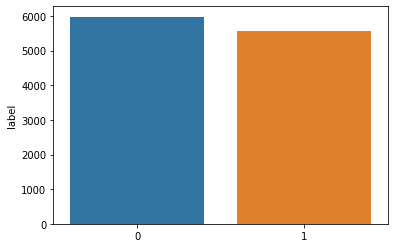

In [ ]:
# plotting class distribution
x = df['label'].value_counts()
sns.barplot(x.index, x)

## Text processing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nltk_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean(text):
  filtered = []
  sentences = nltk.sent_tokenize(text)
  for sentence in sentences:
    sentence = sentence.lower()
    tokens = nltk_tokenizer.tokenize(sentence)
    filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
    filtered.extend(filtered_words)
  return filtered

In [ ]:
df['clean_text'] = df['text'].apply(lambda x: clean(x))
df.head()

,text,label,clean_text
0,WASHINGTON (Reuters) - The U.S. Congress was w...,0,"[washington, reuters, congress, wrestling, hea..."
1,SAN FRANCISCO (Reuters) - California filed a l...,0,"[san, francisco, reuters, california, filed, l..."
2,WASHINGTON (Reuters) - The U.S. Senate on Mond...,0,"[washington, reuters, senate, monday, confirme..."
3,"Donald Trump s son-in-law and senior advisor, ...",1,"[donald, trump, son, law, senior, advisor, jar..."
4,Former reality show star Donald Trump has repe...,1,"[former, reality, show, star, donald, trump, r..."


In [ ]:
corpus = [text for text in df['clean_text']]
corpus[0]

['washington',
 'reuters',
 'congress',
 'wrestling',
 'healthcare',
 'tuesday',
 'lawmakers',
 'parties',
 'considered',
 'approaches',
 'beyond',
 'simply',
 'repealing',
 'replacing',
 'obamacare',
 'widened',
 'healthcare',
 'discussion',
 'appeared',
 'unlikely',
 'yield',
 'dramatic',
 'changes',
 'soon',
 'marked',
 'shift',
 'long',
 'running',
 'republican',
 'effort',
 'gut',
 '2010',
 'patient',
 'protection',
 'affordable',
 'care',
 'act',
 'obamacare',
 'formally',
 'known',
 'republicans',
 'last',
 'attempt',
 'july',
 'overturn',
 'former',
 'democratic',
 'president',
 'barack',
 'obama',
 'signature',
 'healthcare',
 'law',
 'fell',
 'one',
 'short',
 'senate',
 'humiliating',
 'defeat',
 'president',
 'donald',
 'trump',
 'senate',
 'majority',
 'leader',
 'mitch',
 'mcconnell',
 'one',
 'senate',
 'committee',
 'bipartisan',
 'effort',
 'way',
 'tuesday',
 'repair',
 'obamacare',
 'without',
 'repealing',
 'led',
 'republican',
 'health',
 'committee',
 'chairman',

In [ ]:
EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=corpus, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

75462

In [ ]:
# exploring vectors
w2v_model["corona"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.01800725,  0.00422808, -0.00591294,  0.00428865,  0.01137061,
        0.00818267,  0.00063457,  0.00261662, -0.0182735 , -0.01283279,
        0.00584762,  0.00726235, -0.00149045,  0.02164433,  0.00883233,
       -0.01045415,  0.02665832,  0.00242844, -0.00618053,  0.01310779,
       -0.00764524, -0.00327101, -0.00938945, -0.01079839, -0.00120457,
       -0.01057685,  0.01413775,  0.0184036 ,  0.00274281, -0.00821321,
        0.01290542, -0.01585276, -0.00024037,  0.00954775,  0.00446812,
        0.0032678 ,  0.02945859, -0.00441589, -0.00485053,  0.01074407,
        0.0176003 ,  0.00111343,  0.0022597 , -0.00485907,  0.01147739,
       -0.0101071 ,  0.00419377, -0.0016455 , -0.01443238, -0.00417232,
       -0.019979  , -0.00912762, -0.01600803,  0.00455326, -0.00367127,
       -0.00915628,  0.00444547,  0.01384704,  0.00177011,  0.00177968,
       -0.00308014,  0.02204898,  0.01579174,  0.01790479, -0.00379856,
        0.00752236, -0.00365105,  0.00790382, -0.00301582, -0.00

In [ ]:
w2v_model.wv.most_similar("facebook")

[('instagram', 0.7389776706695557),
 ('blog', 0.7293670177459717),
 ('google', 0.720524787902832),
 ('weibo', 0.7080827355384827),
 ('posts', 0.6889984607696533),
 ('page', 0.6790876388549805),
 ('messages', 0.6632435321807861),
 ('text', 0.6592710018157959),
 ('classifieds', 0.6589595079421997),
 ('sinbono', 0.6563298106193542)]

In [ ]:
w2v_model.wv.most_similar("russia")

[('russians', 0.8121219277381897),
 ('kremlin', 0.7714242935180664),
 ('moscow', 0.7701334953308105),
 ('russian', 0.7671973705291748),
 ('putin', 0.7001874446868896),
 ('meddling', 0.6977003812789917),
 ('collusion', 0.6962973475456238),
 ('hacking', 0.696239709854126),
 ('ties', 0.6932521462440491),
 ('hack', 0.6673329472541809)]

## Model training

In [ ]:
# tokenizing text, mapping words to numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

corpus = tokenizer.texts_to_sequences(corpus)

In [ ]:
corpus[0][:10]

[46, 48, 100, 12396, 208, 135, 365, 1413, 852, 6066]

In [ ]:
word_index = tokenizer.word_index
for word, num in word_index.items():
  print(f"{word} -> {num}")
  if num == 10:
    break

trump -> 1
said -> 2
would -> 3
president -> 4
people -> 5
also -> 6
one -> 7
donald -> 8
house -> 9
new -> 10


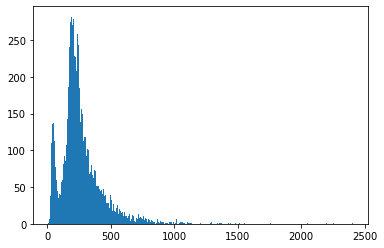

In [ ]:
# plot size of input
plt.hist([len(text) for text in corpus], bins=500)
plt.show()

In [ ]:
# find outliers
outliers = np.array([len(text) for text in corpus])
len(outliers[outliers < 700])

11236

In [ ]:
# truncate text to 700 words
m = 700
corpus = pad_sequences(corpus, maxlen=m)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# create weight matrix from w2v gensim model
def get_weight_matrix(model, vocab):
  # total vocab size + 0 for unknown words
  vocab_size = len(vocab) + 1
  # define weight matrix dimensions with all 0
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  # step vocab, store vectors using integer mapping
  for word, i in vocab.items():
    weight_matrix[i] = model[word]
  return weight_matrix

In [ ]:
# compute embedding vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
# define neural network
model = Sequential()
# non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=m, trainable=False))
# LSTM
model.add(LSTM(units=128))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="acc"
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 700, 100)          7546300   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,663,677
Trainable params: 117,377
Non-trainable params: 7,546,300
_________________________________________________________________


In [ ]:
# splitting dataset
x_train, x_test, y_train, y_test = train_test_split(
    corpus,
    df['label'],
    test_size=0.3
)

x_test

array([[    0,     0,     0, ...,  1697,    83,    79],
       [    0,     0,     0, ...,   357, 10086,  9881],
       [    0,     0,     0, ...,  4795,    16,  6026],
       ...,
       [    0,     0,     0, ...,  1188,   712,  1593],
       [    0,     0,     0, ..., 19946,   395,   871],
       [    0,     0,     0, ...,   104,  1940,   593]], dtype=int32)

In [ ]:
# fit model
hist = model.fit(
    x_train, 
    y_train,
    validation_split=0.3,
    batch_size=32,
    epochs=10
)

Epoch 1/10
177/177 [==============================] - 9s 42ms/step - loss: 0.0562 - acc: 0.9846 - val_loss: 0.0350 - val_acc: 0.9889
Epoch 2/10
177/177 [==============================] - 7s 39ms/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0204 - val_acc: 0.9942
Epoch 3/10
177/177 [==============================] - 7s 40ms/step - loss: 0.0214 - acc: 0.9945 - val_loss: 0.0196 - val_acc: 0.9955
Epoch 4/10
177/177 [==============================] - 7s 39ms/step - loss: 0.0126 - acc: 0.9965 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 5/10
177/177 [==============================] - 7s 39ms/step - loss: 0.0116 - acc: 0.9968 - val_loss: 0.0201 - val_acc: 0.9934
Epoch 6/10
177/177 [==============================] - 7s 39ms/step - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0194 - val_acc: 0.9959
Epoch 7/10
177/177 [==============================] - 7s 39ms/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.0234 - val_acc: 0.9938
Epoch 8/10
177/177 [==============================] - 7s 39ms/step - 

In [ ]:
hist.history

{'loss': [0.05616309121251106,
  0.026018545031547546,
  0.021358149126172066,
  0.012553002685308456,
  0.011617067269980907,
  0.009630036540329456,
  0.008485395461320877,
  0.0024065757170319557,
  0.004440265707671642,
  0.0006920699961483479],
 'acc': [0.9846126437187195,
  0.9922178983688354,
  0.9945171475410461,
  0.9964627027511597,
  0.9968163967132568,
  0.9969933032989502,
  0.9971701502799988,
  0.9994693994522095,
  0.9982313513755798,
  0.9998231530189514],
 'val_loss': [0.03503362089395523,
  0.02043490670621395,
  0.01956726238131523,
  0.01885615848004818,
  0.020120443776249886,
  0.01943049766123295,
  0.023380758240818977,
  0.021912531927227974,
  0.01902959868311882,
  0.020682109519839287],
 'val_acc': [0.9888613820075989,
  0.9942244291305542,
  0.9954620599746704,
  0.9942244291305542,
  0.9933993220329285,
  0.9958745837211609,
  0.9938119053840637,
  0.9921616911888123,
  0.9946369528770447,
  0.9946369528770447]}

Text(0.5, 1.0, 'Accuracy')

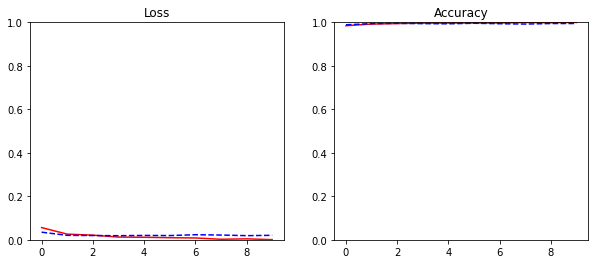

In [ ]:
# loss-accuracy visualisation
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], color="red")
plt.plot(hist.history['val_loss'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], color="red")
plt.plot(hist.history['val_acc'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Accuracy")

## Model evaluation

In [ ]:
# check predictions
prediction = model.predict(x_test)
y_prediction = np.where(prediction > 0.5, 1, 0)

In [ ]:
model.evaluate(y_test, y_prediction)

109/109 [==============================] - 1s 3ms/step - loss: 0.7022 - acc: 0.5227


[0.7021849751472473, 0.522668182849884]

In [ ]:
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_prediction)}")
print(f"Confusion matrix: {metrics.confusion_matrix(y_test, y_prediction)}")
print(metrics.classification_report(y_test, y_prediction))

Accuracy score: 0.9907594571181056
Confusion matrix: [[1790   12]
 [  20 1641]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1802
           1       0.99      0.99      0.99      1661

    accuracy                           0.99      3463
   macro avg       0.99      0.99      0.99      3463
weighted avg       0.99      0.99      0.99      3463



## Saving model

In [ ]:
# save model
model.save('nfn_model.h5')

# save tokenizer
nfn_tokenizer = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(nfn_tokenizer, ensure_ascii=False))

## Load and test model (for demonstration purposes, more convenient than API)

In [ ]:
# import modules
import io, json
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
nltk_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
import tensorflow as tf
import gensim
from tensorflow import keras
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# load model
nfn_model = tf.keras.models.load_model('nfn_model.h5')

# load tokenizer
with open('tokenizer.json') as f:
    tokenizer_json = json.load(f)
    nfn_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

# define clean
def clean(text):
  filtered = []
  sentences = nltk.sent_tokenize(text)
  for sentence in sentences:
    sentence = sentence.lower()
    tokens = nltk_tokenizer.tokenize(sentence)
    filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
    filtered.extend(filtered_words)
  return filtered

In [ ]:
# https://www.theonion.com/nasa-worried-moon-won-t-remember-them-1849492372
onionnews = '''WASHINGTON—In a press conference Monday, NASA administrator Bill Nelson confirmed the biggest concern agency officials had about returning to the moon was that it might not remember them. “It’s been, jeez, what, almost 50 years? We just hope it’s not super awkward,” said Nelson, who noted that NASA astronauts were currently undergoing rigorous training to simulate what it would be like when they landed and the moon gave them a completely blank look. “I’m not saying we’re expecting the worst-case scenario, but, I mean, we haven’t exactly been keeping in touch. Hopefully it still has the flag we got it. My God, though, what if we don’t even recognize it?” At press time, Nelson added that if things with the moon didn’t work out, the space agency would try its luck with Mars.'''
onionnews

'WASHINGTON—In a press conference Monday, NASA administrator Bill Nelson confirmed the biggest concern agency officials had about returning to the moon was that it might not remember them. “It’s been, jeez, what, almost 50 years? We just hope it’s not super awkward,” said Nelson, who noted that NASA astronauts were currently undergoing rigorous training to simulate what it would be like when they landed and the moon gave them a completely blank look. “I’m not saying we’re expecting the worst-case scenario, but, I mean, we haven’t exactly been keeping in touch. Hopefully it still has the flag we got it. My God, though, what if we don’t even recognize it?” At press time, Nelson added that if things with the moon didn’t work out, the space agency would try its luck with Mars.'

In [ ]:
# https://www.bbc.com/news/uk-62875589
bbcnews = '''The Duke of Sussex has paid tribute to his grandmother the Queen, thanking her for her commitment to service, sound advice and "infectious smile". Making his first statement since her death, Prince Harry said: "We, too, smile knowing that you and grandpa are reunited now." He said he was grateful for the memories of the Queen meeting her "beloved great-grandchildren". "We now honour my father in his new role as King Charles III," he added. In his statement, written on his Archewell website, Harry described the Queen as a "guiding compass". "Her unwavering grace and dignity remained true throughout her life and now her everlasting legacy," he added. "Let us echo the words she spoke after the passing of her husband, Prince Philip, words which can bring comfort to all of us now: 'Life, of course, consists of final partings as well as first meetings.'."'''
bbcnews

'The Duke of Sussex has paid tribute to his grandmother the Queen, thanking her for her commitment to service, sound advice and "infectious smile". Making his first statement since her death, Prince Harry said: "We, too, smile knowing that you and grandpa are reunited now." He said he was grateful for the memories of the Queen meeting her "beloved great-grandchildren". "We now honour my father in his new role as King Charles III," he added. In his statement, written on his Archewell website, Harry described the Queen as a "guiding compass". "Her unwavering grace and dignity remained true throughout her life and now her everlasting legacy," he added. "Let us echo the words she spoke after the passing of her husband, Prince Philip, words which can bring comfort to all of us now: \'Life, of course, consists of final partings as well as first meetings.\'."'

In [ ]:
onionnews = clean(onionnews)
onionnews = nfn_tokenizer.texts_to_sequences([onionnews])
onionnews = pad_sequences(onionnews, maxlen=700)

In [ ]:
nfn_model.predict(onionnews)

array([[0.9978059]], dtype=float32)

In [ ]:
bbcnews = clean(bbcnews)
bbcnews = nfn_tokenizer.texts_to_sequences([bbcnews])
bbcnews = pad_sequences(bbcnews, maxlen=700)

In [ ]:
nfn_model.predict(bbcnews)[0][0]

0.00036726994